# Audio Processing Basics (in the context of wing beat signals)
(didactic material, F.H., 5/2020)

**PCM (pulse code modulation):**  method used to digitally represent sampled analog signals. It is the standard form of digital audio (e.g. used in WAV format). In a PCM stream, the amplitude of the analog signal is sampled regularly at uniform intervals, and each sample is quantized to the nearest value within a range of digital steps.
   + LPCM: Linear pulse code Modulation (quantization levels are uniform)
   + PCM characterized by
      - **sample rate**: number of samples per second (also called sample frequency)
      - **bit depth**: number of bits per sample    
      
**WAV (Waveform Audio File Format):** (From filename  extension .wav .)  Audio file format standard, often using uncompressed LPCM. Data Container with Header and data.

**SNR (signal to noise ratio):** ratio of (mean) signal power and (mean) noise power (power is usually obtained as the  square of  the signal and of the noise, respectively)    

$$\mathrm{SNR} = \frac{P_{\mathrm{signal}}}{P_{\mathrm{noise}}}$$   
 often in $\mathrm{dB}$ (second equality: $P$ has to be dimensionless):
$$\mathrm{SNR} = 10 \log \left( \frac{P_{\mathrm{signal}}}{P_{\mathrm{noise}}} \right) \mathrm{dB}
                = 10 \log P_{\mathrm{signal}} - 10 \log {P_{\mathrm{noise}}}$$   


+ average power of a Gaussian random signal with mean $\mu$ and variance $\sigma^2$ (expectation value of the square of the random variable):

$$P_{\mathrm{noise}} = \mu^2 + \sigma^2$$

+ Additive Gaussian White Noise (AGWN): add a  Gaussian  random signal with mean $\mu=0$ to the signal.   
Assume $\mathrm{SNR}$ ist given, then 

$$\sigma^2 = \frac{P_{\mathrm{signal}}}{\mathrm{SNR}}$$
in $\mathrm{dB}$
$$20 \log \sigma =  10 \log P_{\mathrm{signal}} - 10 \log \mathrm{SNR} = P_{\mathrm{signal}}[\mathrm{dB}] - 
  \mathrm{SNR} [\mathrm{dB}]  $$
  
$$ \sigma = 10^{(P_{\mathrm{signal}}[\mathrm{dB}] - \mathrm{SNR} [\mathrm{dB}]) / 20 }$$ 




## Generate example of a wingbeat signal
+ In order to understand some basic principles on analysing Wingbeat signals,  we generate a *clean* synthetic example of an *ideal* Wingbeat signal:

    - base frequency: $\nu_0 = 243\, \mathrm{Hz}$   
    - first harmonic: $\nu_1 = 486\, \mathrm{Hz}$   
    - $n^{th}$ harmonic: $\nu_{n} = (n+1) \nu_0$
 
    - body movement: $\nu_b = 5\, \mathrm{Hz}$      
    

+ we add some noise: additive Gaussian white  noise , $\mathrm{SNR} = 20 \mathrm{dB} \equiv 100:1$ or $\mathrm{SNR} = 30 \mathrm{dB} \equiv 1000:1$ 


+ we use a digital signal:
    - bit depth of digital signal: 16   ( data type int16 $\equiv$ short )
    - sampling rate: 16000   
 
 
+ we may use a low pass filter with cut off frequency 1500 Hz


In [35]:
from ipywidgets import widgets
check = widgets.Checkbox(
    value=False,
    description='Low Pass Filter ?',
    disabled=False,
    indent=False
)
check

Checkbox(value=False, description='Low Pass Filter ?', indent=False)

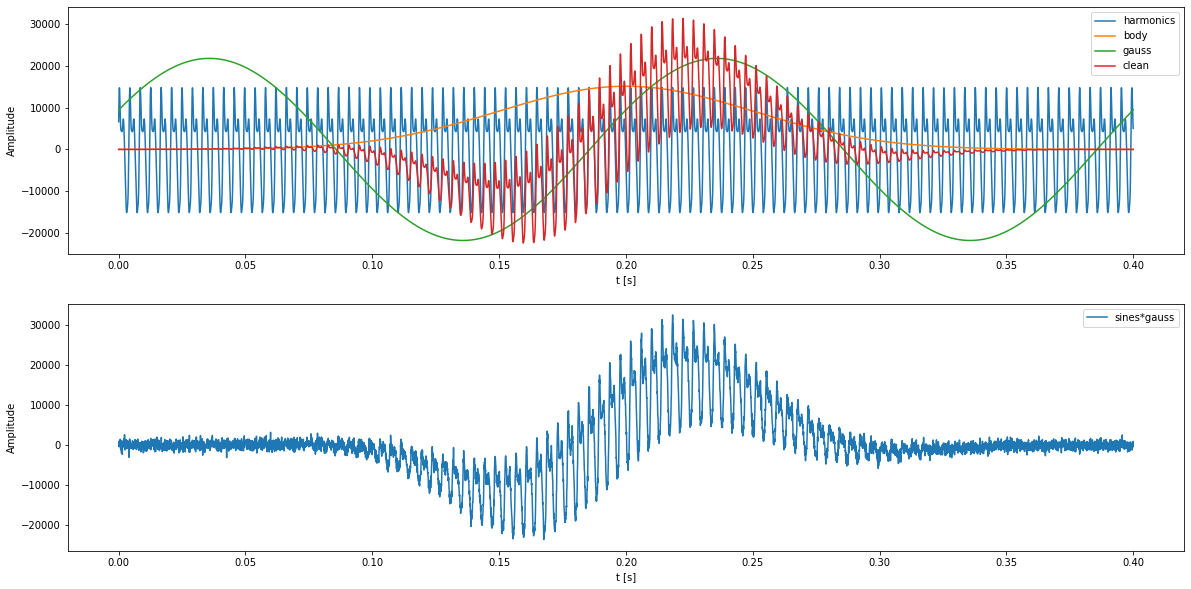

In [42]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

MAX_AMPLITUDE  = np.iinfo(np.int16).max # = 32767 # = 2**15 - 1, 16-bit datatype for signals: int16 (signed)
sampling_rate  = 16000.
base_freq      = 243. # [Hz]
body_freq      = 5.   # [Hz]
snr            = 20  # [dB]  i.e. snr = 1.e(snr/10) : 1
LOW_PASS       = check.value

#  analog signals 
def sine_signal(t, freq=1000, amplitude=1, phase=0.):
    return amplitude*np.sin(2*np.pi*freq*t + phase)

def gauss_signal(t, mu=0.5, s=0.5, z=1):
    return z*np.exp(- (t-mu)*(t-mu)/(2.*s*s) )

# digital time steps
t_span      = [0., 0.4]
num_samples = int( np.ceil((t_span[1] - t_span[0])*sampling_rate))
t           = np.linspace( t_span[0], t_span[1], num_samples)

# wave packet signal: Wingbeat Recorder operates ideally (multiplying a Gauss function ) 
amp1 = MAX_AMPLITUDE/3
amp2 = MAX_AMPLITUDE/5

signal_body     = sine_signal(t, freq=body_freq, amplitude=amp1*2, phase=np.pi/7)
signal1a        = sine_signal(t, freq=base_freq, amplitude=amp1)  #  base frequency 
signal1b        = sine_signal(t, freq=base_freq*2, amplitude=amp2, phase=np.pi/3) #  first harmonic 
signal1c        = sine_signal(t, freq=base_freq*3, amplitude=amp2/3, phase=np.pi/13) #  second harmonic 
signal1d        = sine_signal(t, freq=base_freq*4, amplitude=amp2/5, phase=np.pi/11) #  third harmonic
signal1e        = sine_signal(t, freq=base_freq*5, amplitude=amp2/7, phase=np.pi/37) #  third harmonic
signal_harmonic = signal1a + signal1b + signal1c + signal1d + signal1e
signal_gauss    = gauss_signal(t, mu=0.2, s=0.05, z=1)

signal_clean    = (signal_body + signal_harmonic)*signal_gauss 

# add noise 
signal_power    = 10*np.log10( np.mean(signal_clean*signal_clean) )
sigma_noise     = 10**((signal_power - snr)/20) 
signal_noise    = np.random.normal(0, sigma_noise, len(t))

signal_total    = signal_clean + signal_noise

if LOW_PASS == True:
    from scipy import signal
    cut_off_freq = 2000.
    b, a = signal.butter(3, cut_off_freq, btype="lowpass", fs=2*sampling_rate)
    signal_total = signal.filtfilt(b, a, signal_total)    

# visualization
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(t, signal_harmonic)
amp3 = np.max(abs(signal_harmonic))
ax1.plot(t, signal_gauss*(amp3) ) 
ax1.plot(t, signal_body)  
ax1.plot(t, signal_clean)  
ax1.set_xlabel('t [s]')
ax1.set_ylabel('Amplitude')
ax1.legend(['harmonics', 'body', 'gauss', 'clean'])

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(t, signal_total)
ax2.set_xlabel('t [s]')
ax2.set_ylabel('Amplitude')
ax2.legend(['sines*gauss'])
#ax2.set_xlim(0.1,0.3)
plt.show()

# sound 
from IPython.display import Audio
Audio(signal_total, rate=sampling_rate) # hear the sound of the wingbeat

## 1. Recover base frequency and higher harmonics from DFT (FFT)


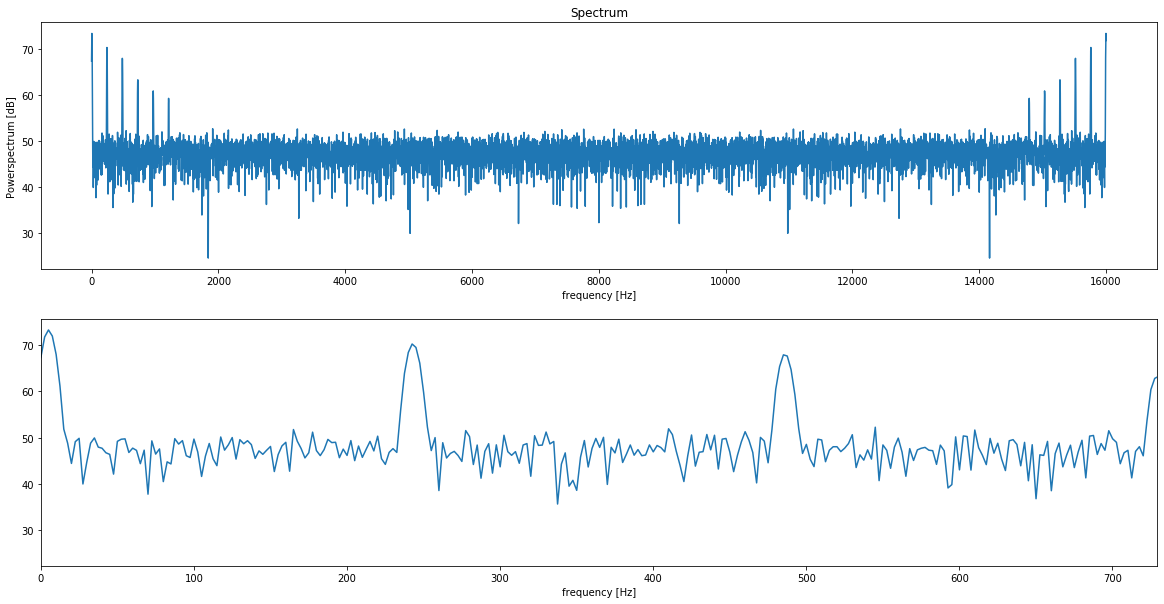

In [43]:
from numpy.fft import fft, ifft
%matplotlib inline

f1      = sampling_rate/len(t)   # smallest frequency in fft; fk = k*f1
n_base  = int(base_freq/f1)  # index of corresponding Fourier coefficient'

spectrum = 10*np.log10(np.abs(fft(signal_total)) )
freqs    = np.linspace(0, sampling_rate, len(t)) 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(freqs, spectrum)
ax1.set_xlabel('frequency [Hz]')
ax1.set_title('Spectrum')
ax1.set_ylabel('Powerspectrum [dB]')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(freqs, spectrum)
ax2.set_xlabel('frequency [Hz]')
ax2.set_xlim(0, 3*base_freq)

plt.show()

In [44]:
from scipy.signal import argrelmax
import pandas as pd
n = len(spectrum)
half_spectrum =  pd.Series(spectrum[0:n//2])
harmonics_ind = half_spectrum.nlargest()
harmonics = harmonics_ind.index*f1
#harmonics = [k*f1  for k in argrelmax( half_spectrum, order=10)[0]]
print("Harmonics (and body frequency): ", harmonics )

Harmonics (and body frequency):  Float64Index([5.0, 7.5, 2.5, 242.5, 245.0], dtype='float64')


## 2. Get base frequency from cepstrum   
**cepstrum** idea: take spectrum of the spectrum, i.e. find periodic structures in the (power-) spectrum  
+ the cepstrum of a signal $s(t)$ is defined as (taking squares doesn't make much difference because of the log)   
$c_p = |\mathcal{F}^{-1} ( \log ( |\mathcal{F}(s)| ) |$
+ time -- frequency -- *quefrequency*
+ if base frequency and higher harmonics are present in $s(t)$, they together lead to a prominent peak in the cepstrum (hopefully the largest)
+ interpretation: quefrency is a time scale; 1./quefrency ist the corresponding base frequency   
( in the frequency signal $\mathcal{F}$ the part with period *base frequency* ) 
+ theory: convolved time signals lead to a product in frequency space and a sum after taking the log ... . In some sense the cepstrum leads to a deconvolution, i.e. the convolution kernel does become a summand. Does work very well for human voices.
+ generalization: Mel Frequency Cepstral Coefficients (MFCC) - prominent in speech recognition systems; could be used as features for classification


<function matplotlib.pyplot.show(*args, **kw)>

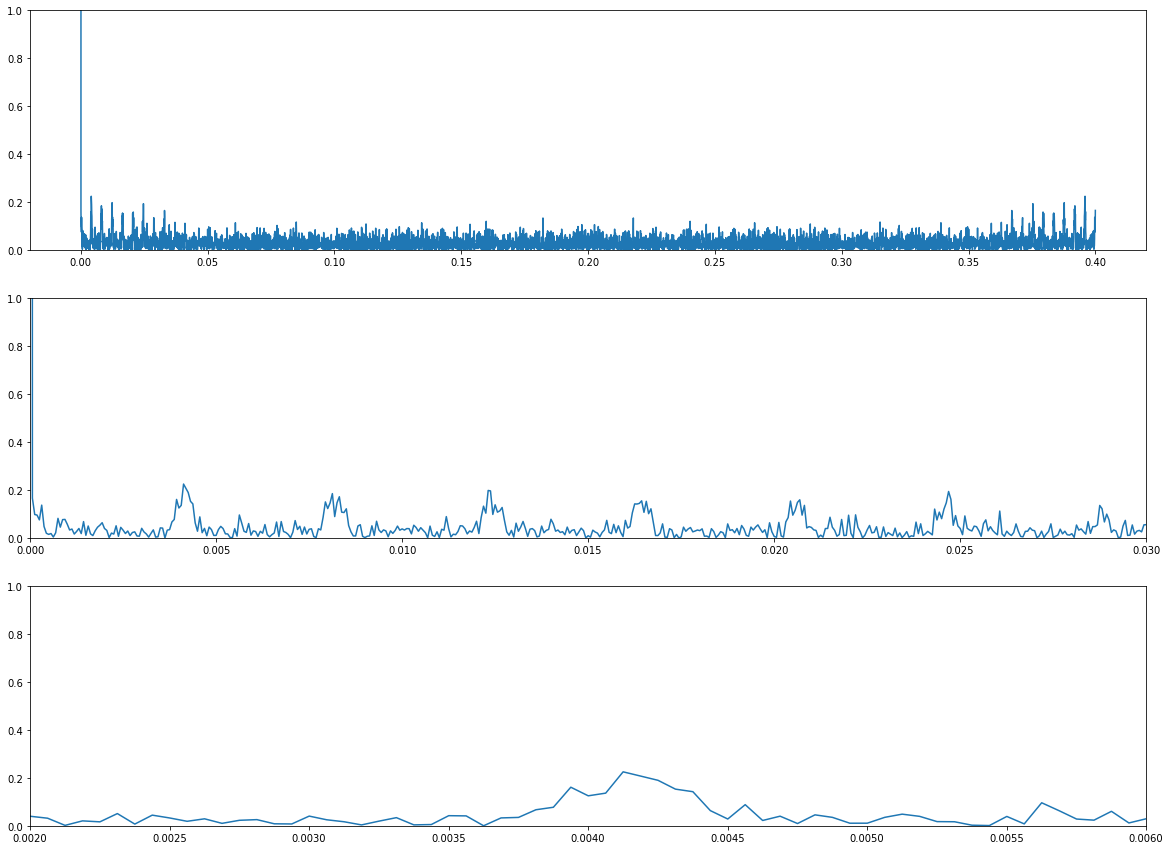

In [46]:
cepstrum = np.abs( ifft(spectrum) )
#cepstrum[0:2] = 0
#cepstrum[-3:] = 0

%matplotlib inline

fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(311)
ax.plot(t,np.real(cepstrum))
ax.set_ylim(0.0, 1.)

ax = fig.add_subplot(312)
ax.plot(t, cepstrum)
ax.set_xlim(0.0, 0.03)
ax.set_ylim(0.0, 1.)

ax = fig.add_subplot(313)
ax.plot(t, cepstrum)
ax.set_xlim(0.002, 0.006)
ax.set_ylim(0.0, 1.)

plt.show


In [47]:
off_set =  int(sampling_rate/1000)   # sample rate / offset : max frequency allowed, should be < 1000
ind_max =  np.argmax( np.abs(cepstrum[off_set:len(cepstrum)//2]) ) + off_set
f_cepstrum = 1./t[ind_max]
print('base frequency from cepstrum: %.2f' %(f_cepstrum))

base frequency from cepstrum: 242.39


## 3. Use Welch Power Spectral Density, or Short Time Fourier Transform

In [ ]:
#


## 4. Using Spectogram

In [ ]:
# or scipy.signal.periodogram   ?


## Todos 
 
Beispiel Modulation / Demodulation
